In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import seaborn as sns

In [51]:
def load_dataset(dataset_path):
    images=[]
    labels=[]

    for i in range(1,41):
        sub_dir=os.path.join(dataset_path,'s'+str(i))
        for j in range(1,11):
            image_path=os.path.join(sub_dir,str(j)+'.pgm')
            img=Image.open(image_path)
            img_array=np.array(img).flatten()
            images.append(img_array)
            labels.append(i-1)

    h,w=np.array(Image.open(image_path)).shape
    return np.array(images), np.array(labels),h,w


In [52]:
load_dataset('archive')

(array([[ 48,  49,  45, ...,  47,  46,  46],
        [ 60,  60,  62, ...,  32,  34,  34],
        [ 39,  44,  53, ...,  29,  26,  29],
        ...,
        [125, 119, 124, ...,  36,  39,  40],
        [119, 120, 120, ...,  89,  94,  85],
        [125, 124, 124, ...,  36,  35,  34]],
       shape=(400, 10304), dtype=uint8),
 array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15,

In [53]:
class PCA:

    def __init__(self,n_components):
        self.n_components=n_components
        self.mean=None
        self.eigenfaces=None

    def fit(self,X):
        self.mean=np.mean(X,axis=0)

        X_centered=X-self.mean
         
        L=X_centered @ X_centered.T 

        eigenvalues,eigenvectors=np.linalg.eigh(L) 

        eigenfaces=X_centered.T @ eigenvectors

        eigenfaces=eigenfaces/np.linalg.norm(eigenfaces,axis=0)

        sorted_idx=np.argsort(eigenvalues)[::-1]
        sorted_eigenfaces = eigenfaces[:, sorted_idx]
        self.eigenfaces = sorted_eigenfaces[:, :self.n_components]

    
    def project(self,X):
        X_centered=X-self.mean
        return X_centered @ self.eigenfaces
    
    def reconstruct(self,X_projected):
        return (X_projected @ self.eigenfaces.T) + self.mean

In [54]:
def nearest_neighbor_classifier(X_train_proj,y_train,X_test_proj): 
    y_pred=[]

    for ts in X_test_proj:
        distances=np.linalg.norm(X_train_proj-ts,axis=1)
        nearest_idx=np.argmin(distances)
        y_pred.append(y_train[nearest_idx])
    
    return np.array(y_pred)

In [55]:
def calculate_accuracy(y_true,y_pred):
    return np.sum(y_true==y_pred)/len(y_true)


In [56]:
print("1. Loading and preprocessing data...")
images, labels, h, w = load_dataset('archive')


X_train,X_test,y_train,y_test=train_test_split(images,labels,test_size=0.2,random_state=42,stratify=labels)


print(f"Dataset loaded: {len(images)} images")
print(f"Image resolution: {h}x{w}")
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

1. Loading and preprocessing data...
Dataset loaded: 400 images
Image resolution: 112x92
Training set size: 320
Test set size: 80



2. Performing PCA and visualizing Eigenfaces...


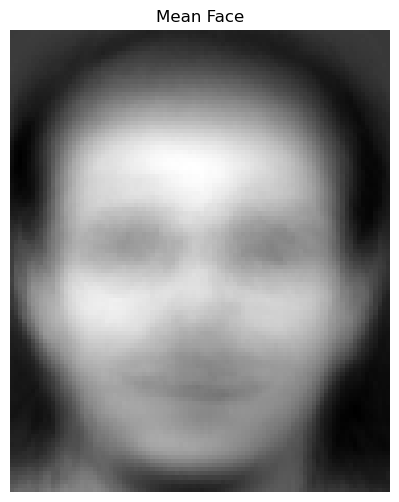

In [57]:
print("\n2. Performing PCA and visualizing Eigenfaces...")
N_COMPONENTS=150
pca=PCA(n_components=N_COMPONENTS)
pca.fit(X_train)

plt.figure(figsize=(6,6))
plt.imshow(pca.mean.reshape(h, w), cmap='gray')
plt.title("Mean Face")
plt.axis('off')
plt.show()

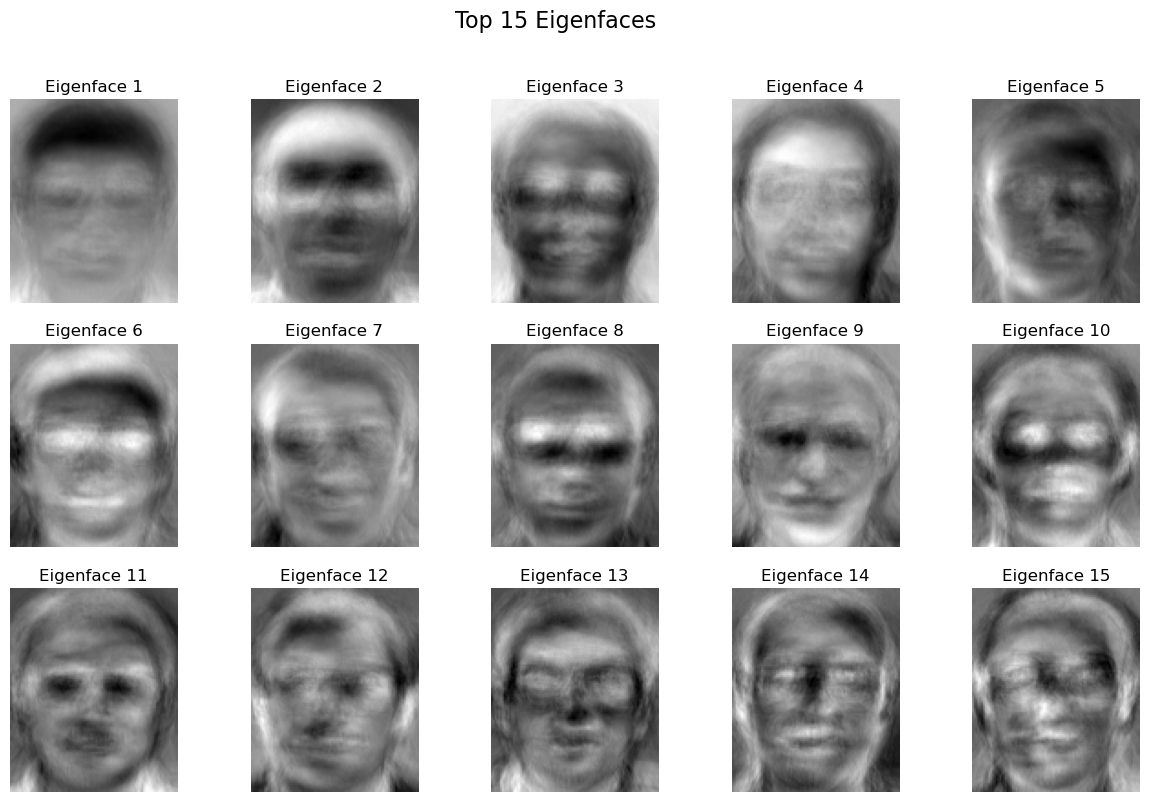

In [58]:
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.eigenfaces[:, i].reshape(h, w), cmap='gray')
    ax.set_title(f"Eigenface {i+1}")
    ax.axis('off')
fig.suptitle("Top 15 Eigenfaces", fontsize=16)
plt.show()


4. Reconstructing images using PCA...


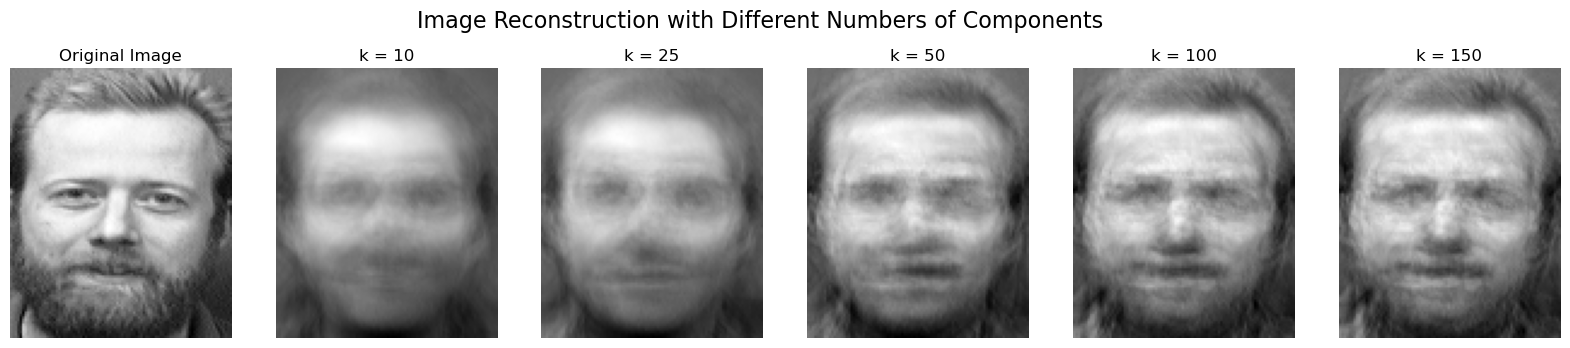

In [ ]:
print("\n4. Reconstructing images using PCA...")

test_image = X_test[10]

components_to_test = [10, 25, 50, 100, 150]
fig, axes = plt.subplots(1, len(components_to_test) + 1, figsize=(20, 4))
axes[0].imshow(test_image.reshape(h, w), cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

for i, k in enumerate(components_to_test):
    pca_k = PCA(n_components=k)
    pca_k.fit(X_train)
    
    projected_image = pca_k.project(np.array([test_image]))
    reconstructed_image = pca_k.reconstruct(projected_image)
    
    axes[i+1].imshow(reconstructed_image.reshape(h, w), cmap='gray')
    axes[i+1].set_title(f"k = {k}")
    axes[i+1].axis('off')

fig.suptitle("Image Reconstruction with Different Numbers of Components", fontsize=16)
plt.show()


5 & 6. Performing face recognition and analyzing performance...


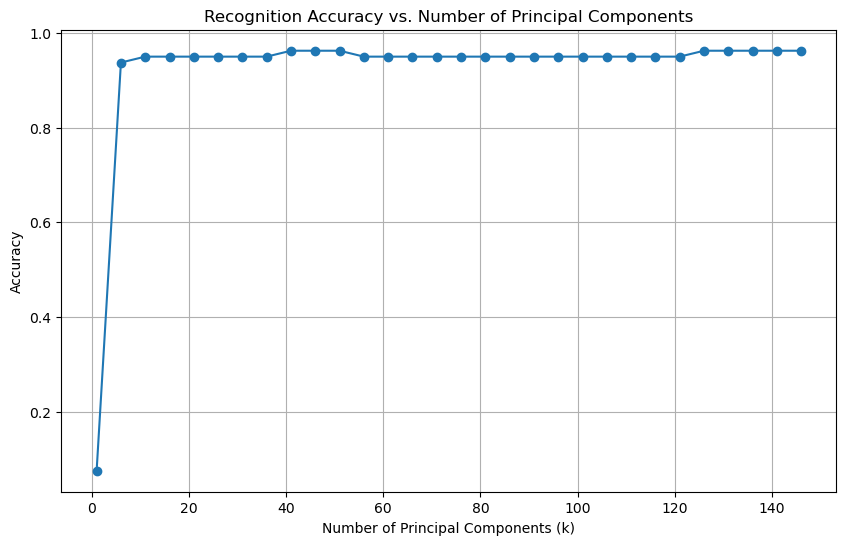


Maximum accuracy of 0.9625 achieved at k = 41.
Discussion: The plot shows that accuracy increases as we add more components,
as more facial variance is captured. It typically plateaus after a certain point,
because additional components might be capturing noise rather than useful features.


In [60]:
print("\n5 & 6. Performing face recognition and analyzing performance...")
accuracies = []
k_values = list(range(1, 151, 5)) 

for k in k_values:
    pca_k=PCA(n_components=k)
    pca_k.fit(X_train)

    X_train_proj=pca_k.project(X_train)
    X_test_proj=pca_k.project(X_test)

    y_pred = nearest_neighbor_classifier(X_train_proj, y_train, X_test_proj)

    accuracy = calculate_accuracy(y_test, y_pred)
    accuracies.append(accuracy)

plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-')
plt.title("Recognition Accuracy vs. Number of Principal Components")
plt.xlabel("Number of Principal Components (k)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

best_k = k_values[np.argmax(accuracies)]
max_accuracy = max(accuracies)
print(f"\nMaximum accuracy of {max_accuracy:.4f} achieved at k = {best_k}.")
print("Discussion: The plot shows that accuracy increases as we add more components,")
print("as more facial variance is captured. It typically plateaus after a certain point,")
print("because additional components might be capturing noise rather than useful features.")


7. Visualizing PCA features with t-SNE...


c:\Users\athar\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\athar\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\athar\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\athar\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^

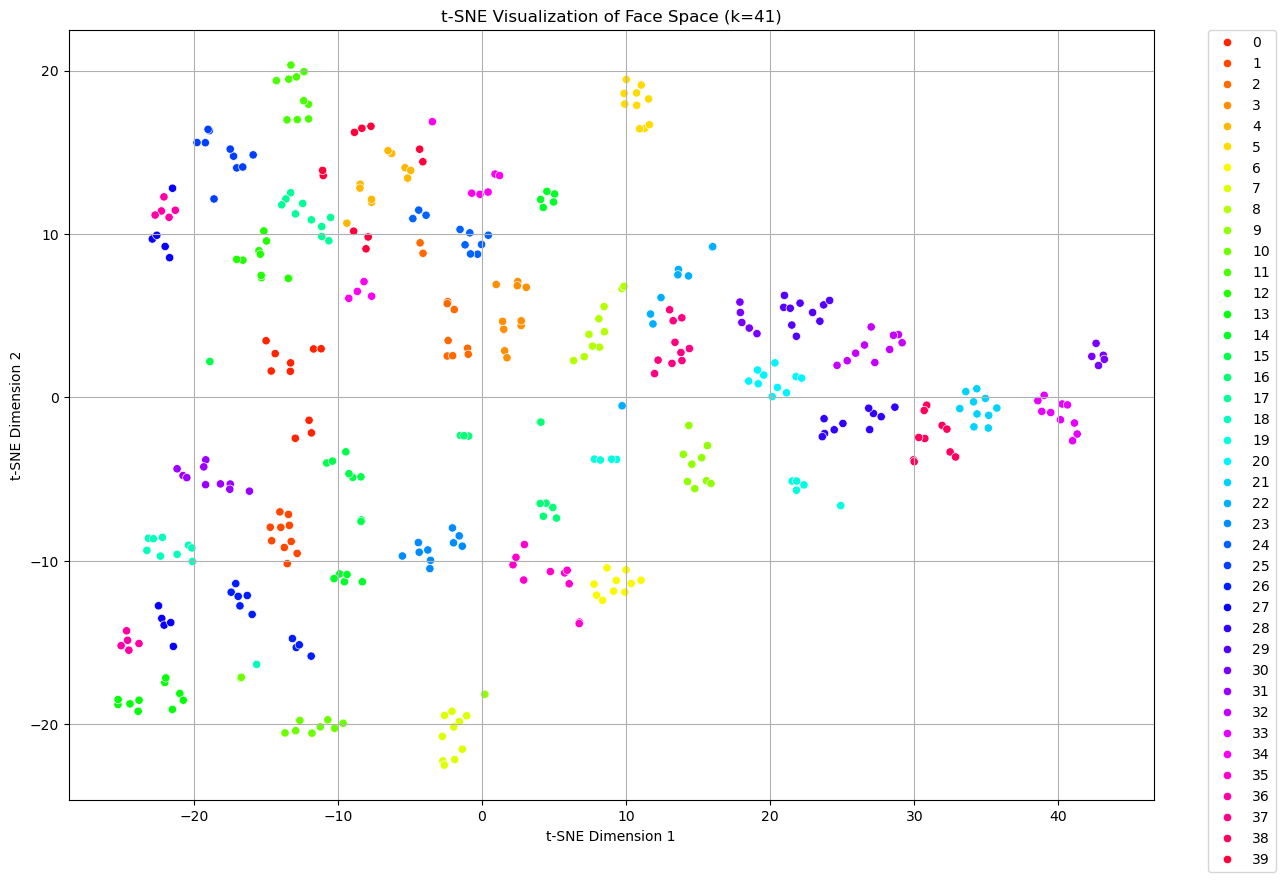


Comment on t-SNE plot: The visualization shows how well the PCA features
separate the different subjects. Ideally, images of the same person (same color)
should form distinct clusters, indicating that the Eigenface representation is effective
at capturing unique facial features for recognition.


In [ ]:
print("\n7. Visualizing PCA features with t-SNE...")
# Use the best number of components found previously
pca_tsne = PCA(n_components=best_k)
pca_tsne.fit(X_train)

all_images_proj=pca_tsne.project(images)

tsne=TSNE(n_components=2, random_state=42)
tsne_results=tsne.fit_transform(all_images_proj)

plt.figure(figsize=(14, 10))
sns.scatterplot(
    x=tsne_results[:, 0],
    y=tsne_results[:, 1],
    hue=labels,
    palette=sns.color_palette("hsv", 40), 
    legend='full'
)
plt.title(f't-SNE Visualization of Face Space (k={best_k})')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.show()

print("\nComment on t-SNE plot: The visualization shows how well the PCA features")
print("separate the different subjects. Ideally, images of the same person (same color)")
print("should form distinct clusters, indicating that the Eigenface representation is effective")
print("at capturing unique facial features for recognition.")

